# MNIST American Sign Language Alphabet Classification Using CNN

The MNIST database for American Sign Language (ASL) contains images of hand signs for the different letters of the alphabet. Our data comes somewhat preprocessed with the original coloured images being scaled down to 28x28 grayscaled images. The pixels of these images were then converted into their 255 code and then put into a csv. In order to predict and correctly classify signs, we can use convoluted neural networks (CNN).

## Preprocessing

To preprocess the data for use in our CNNs, we first import the data.

In [1]:
### importing relevant libraries ###

import pandas as pd
import numpy as np

In [2]:
### importing data ###

df_train_raw = pd.read_csv('data/sign_mnist_train.csv') # raw train data
df_test_raw = pd.read_csv('data/sign_mnist_test.csv') # raw test data

Now we look at the data to see how it might need to be preprocessed.

In [3]:
### looking at train data ###

df_train_raw.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
### looking at test data ###

df_test_raw.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [5]:
### looking at dataframe shapes ###

train_shape = df_train_raw.shape
test_shape = df_test_raw.shape

print("Train shape is", train_shape, "and test shape is", test_shape)

Train shape is (27455, 785) and test shape is (7172, 785)


We can see that the train and test data have the same features so any preprocessing that we do to one we can do to the other. First we separate the labels since they contain our class information.

In [6]:
### separating labels ###

# labels
df_train_y = df_train_raw['label']
df_test_y = df_test_raw['label']

# dropping labels from original data
df_train_raw_X = df_train_raw.drop('label', axis = 1)
df_test_raw_X = df_test_raw.drop('label', axis = 1)

Now we reshape the features so that it will fit into a CNN and then scale it.

In [7]:
### reshaping and scaling data ###

df_train_X = df_train_raw_X.values.reshape(df_train_raw_X.shape[0], 28, 28, 1) / 255.
df_test_X = df_test_raw_X.values.reshape(df_test_raw_X.shape[0], 28, 28, 1) / 255.

Finally, we have processed data that we can use for our CNN. 

## Exploratory Data Analysis

In our exploratory data analysis (EDA), we check to see how the classes are distributed in the train data. If the train data is skewed towards certain classes, it may be difficult to accurately predict the underrepresented classes since their features might not be accurately extracted.

In [8]:
### importing libraries ###

import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Value Counts of Labels')

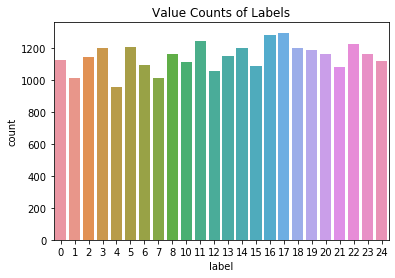

In [9]:
### visualizing labels ###

sns.countplot(x = df_train_y)
plt.title('Value Counts of Labels')

We can see that the classes are relatively well distributed. We can note, however, that there are only 24 classes but the alphabet has 26 letters. This is due to the exclusion of the letters J (class = 9) and Z (class = 25) as they are not static hand gestures. Now let's see what a potential image looks like. 

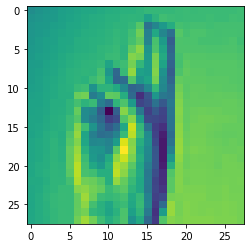

In [10]:
### Visualization of Image ###

plt.imshow(df_train_X[42].reshape(28, 28))

The image can visibly be seen to be the letter U. We can now proceed to modelling.

## Modelling

Now that our preprocessing and EDA are complete, we can use CNNs to model our data.

In [11]:
### import libraries ###

import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Flatten
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


First we build our classifier.

In [12]:
### building our CNN classifier ###

def build_classifier():
    
    # classifier
    classifier = Sequential()
    
    # convolution layer and max pooling twice
    classifier.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    
    classifier.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    
    # flattening
    classifier.add(Flatten())
    
    # dense layer
    classifier.add(Dense(128, activation = 'relu'))
    classifier.add(Dropout(0.2)) # dropout
    
    # output layer
    classifier.add(Dense(24, activation = 'softmax'))
    
    # compilation
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 128, epochs = 50)

We now hot encode the labels so that we can have an outer layer of 24 while including letter Y and ignoring letter J.

In [13]:
### dummy variables ###

train_y = pd.get_dummies(df_train_y)
test_y = pd.get_dummies(df_test_y)

Now we can try to fit a model.

In [14]:
### fitting a model ###

history = classifier.fit(df_train_X, train_y, validation_data = (df_test_X, test_y))

Train on 27455 samples, validate on 7172 samples
Epoch 1/50
27455/27455 [==============================] - 5s 174us/step - loss: 1.8411 - accuracy: 0.4503 - val_loss: 0.9064 - val_accuracy: 0.7111
Epoch 2/50
27455/27455 [==============================] - 3s 116us/step - loss: 0.5539 - accuracy: 0.8216 - val_loss: 0.5138 - val_accuracy: 0.8210
Epoch 3/50
27455/27455 [==============================] - 3s 117us/step - loss: 0.2521 - accuracy: 0.9238 - val_loss: 0.3356 - val_accuracy: 0.8992
Epoch 4/50
27455/27455 [==============================] - 3s 117us/step - loss: 0.1213 - accuracy: 0.9674 - val_loss: 0.3249 - val_accuracy: 0.8893
Epoch 5/50
27455/27455 [==============================] - 3s 116us/step - loss: 0.0708 - accuracy: 0.9826 - val_loss: 0.2884 - val_accuracy: 0.9110
Epoch 6/50
27455/27455 [==============================] - 3s 117us/step - loss: 0.0470 - accuracy: 0.9885 - val_loss: 0.2677 - val_accuracy: 0.9226
Epoch 7/50
27455/27455 [==============================] - 3s 11

Now we plot the loss of the train and test set as a function of epochs.

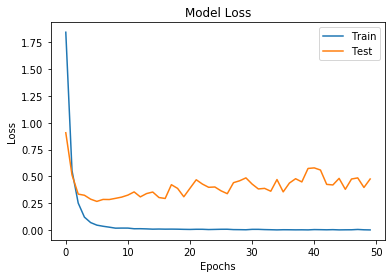

In [15]:
### plotting loss ###

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc = 'upper right')

We can see that the model learns the training set quite quickly with a low number of epochs. However, the train loss fluctuates after about epoch = 5 which may be due to overtraining since only a low number of epochs is needed. As a result, we will fit the model to a low number of epochs.

In [16]:
### fitting new model ###

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 128, epochs = 5)
classifier.fit(df_train_X, train_y, validation_data = (df_test_X, test_y))

Train on 27455 samples, validate on 7172 samples
Epoch 1/5
27455/27455 [==============================] - 4s 131us/step - loss: 1.8741 - accuracy: 0.4404 - val_loss: 0.9280 - val_accuracy: 0.7129
Epoch 2/5
27455/27455 [==============================] - 3s 127us/step - loss: 0.5469 - accuracy: 0.8285 - val_loss: 0.5035 - val_accuracy: 0.8296
Epoch 3/5
27455/27455 [==============================] - 3s 127us/step - loss: 0.2442 - accuracy: 0.9277 - val_loss: 0.3358 - val_accuracy: 0.8982
Epoch 4/5
27455/27455 [==============================] - 3s 125us/step - loss: 0.1199 - accuracy: 0.9675 - val_loss: 0.2885 - val_accuracy: 0.9225
Epoch 5/5
27455/27455 [==============================] - 3s 127us/step - loss: 0.0684 - accuracy: 0.9833 - val_loss: 0.2277 - val_accuracy: 0.9318


Now that we have our new model, we will use cross validation to see if what we are getting is an accurate representation.

In [17]:
### 10 fold cross validation ###

# cross validation
cross_val = cross_val_score(estimator = classifier,
                           X = df_train_X,
                           y = train_y,
                           cv = 10)



Epoch 1/5
24709/24709 [==============================] - 3s 111us/step - loss: 2.1784 - accuracy: 0.3546
Epoch 2/5
24709/24709 [==============================] - 2s 101us/step - loss: 0.7438 - accuracy: 0.7594
Epoch 3/5
24709/24709 [==============================] - 2s 100us/step - loss: 0.3647 - accuracy: 0.8828
Epoch 4/5
24709/24709 [==============================] - 2s 101us/step - loss: 0.1949 - accuracy: 0.9434
Epoch 5/5
2746/2746 [==============================] - 0s 84us/step
Epoch 1/5
24709/24709 [==============================] - 3s 106us/step - loss: 1.9126 - accuracy: 0.4287
Epoch 2/5
24709/24709 [==============================] - 2s 100us/step - loss: 0.5831 - accuracy: 0.8165
Epoch 3/5
24709/24709 [==============================] - 3s 102us/step - loss: 0.2691 - accuracy: 0.9202
Epoch 4/5
24709/24709 [==============================] - 2s 100us/step - loss: 0.1344 - accuracy: 0.9621
Epoch 5/5
2746/2746 [==============================] - 0s 59us/step
Epoch 1/5
24709/24709 [=

In [18]:
### results of cross validation ###

# mean and variance
mean = cross_val.mean()
variance = cross_val.std()

print('The mean of the k fold accuracies is:', mean, 'and the variance is:', variance)

The mean of the k fold accuracies is: 0.9986522793769836 and the variance is: 0.0013439093261746282


The cross validation shows an extremely high accuracy with low variance which is good. The accuracy of our new model fits within this accuracy and variance so we accept the model as being a good representation.

In [19]:
### accuracy on train data ###

classifier.score(df_train_X, train_y)

27455/27455 [==============================] - 1s 46us/step


0.9995265007019043

In [20]:
### accuracy on test data ###

classifier.score(df_test_X, test_y)

7172/7172 [==============================] - 0s 46us/step


0.9318181872367859

The accuracy of the train data and the test data are quite high. Now we will look to see where the model is going wrong on the test data to see if we can improve the model.

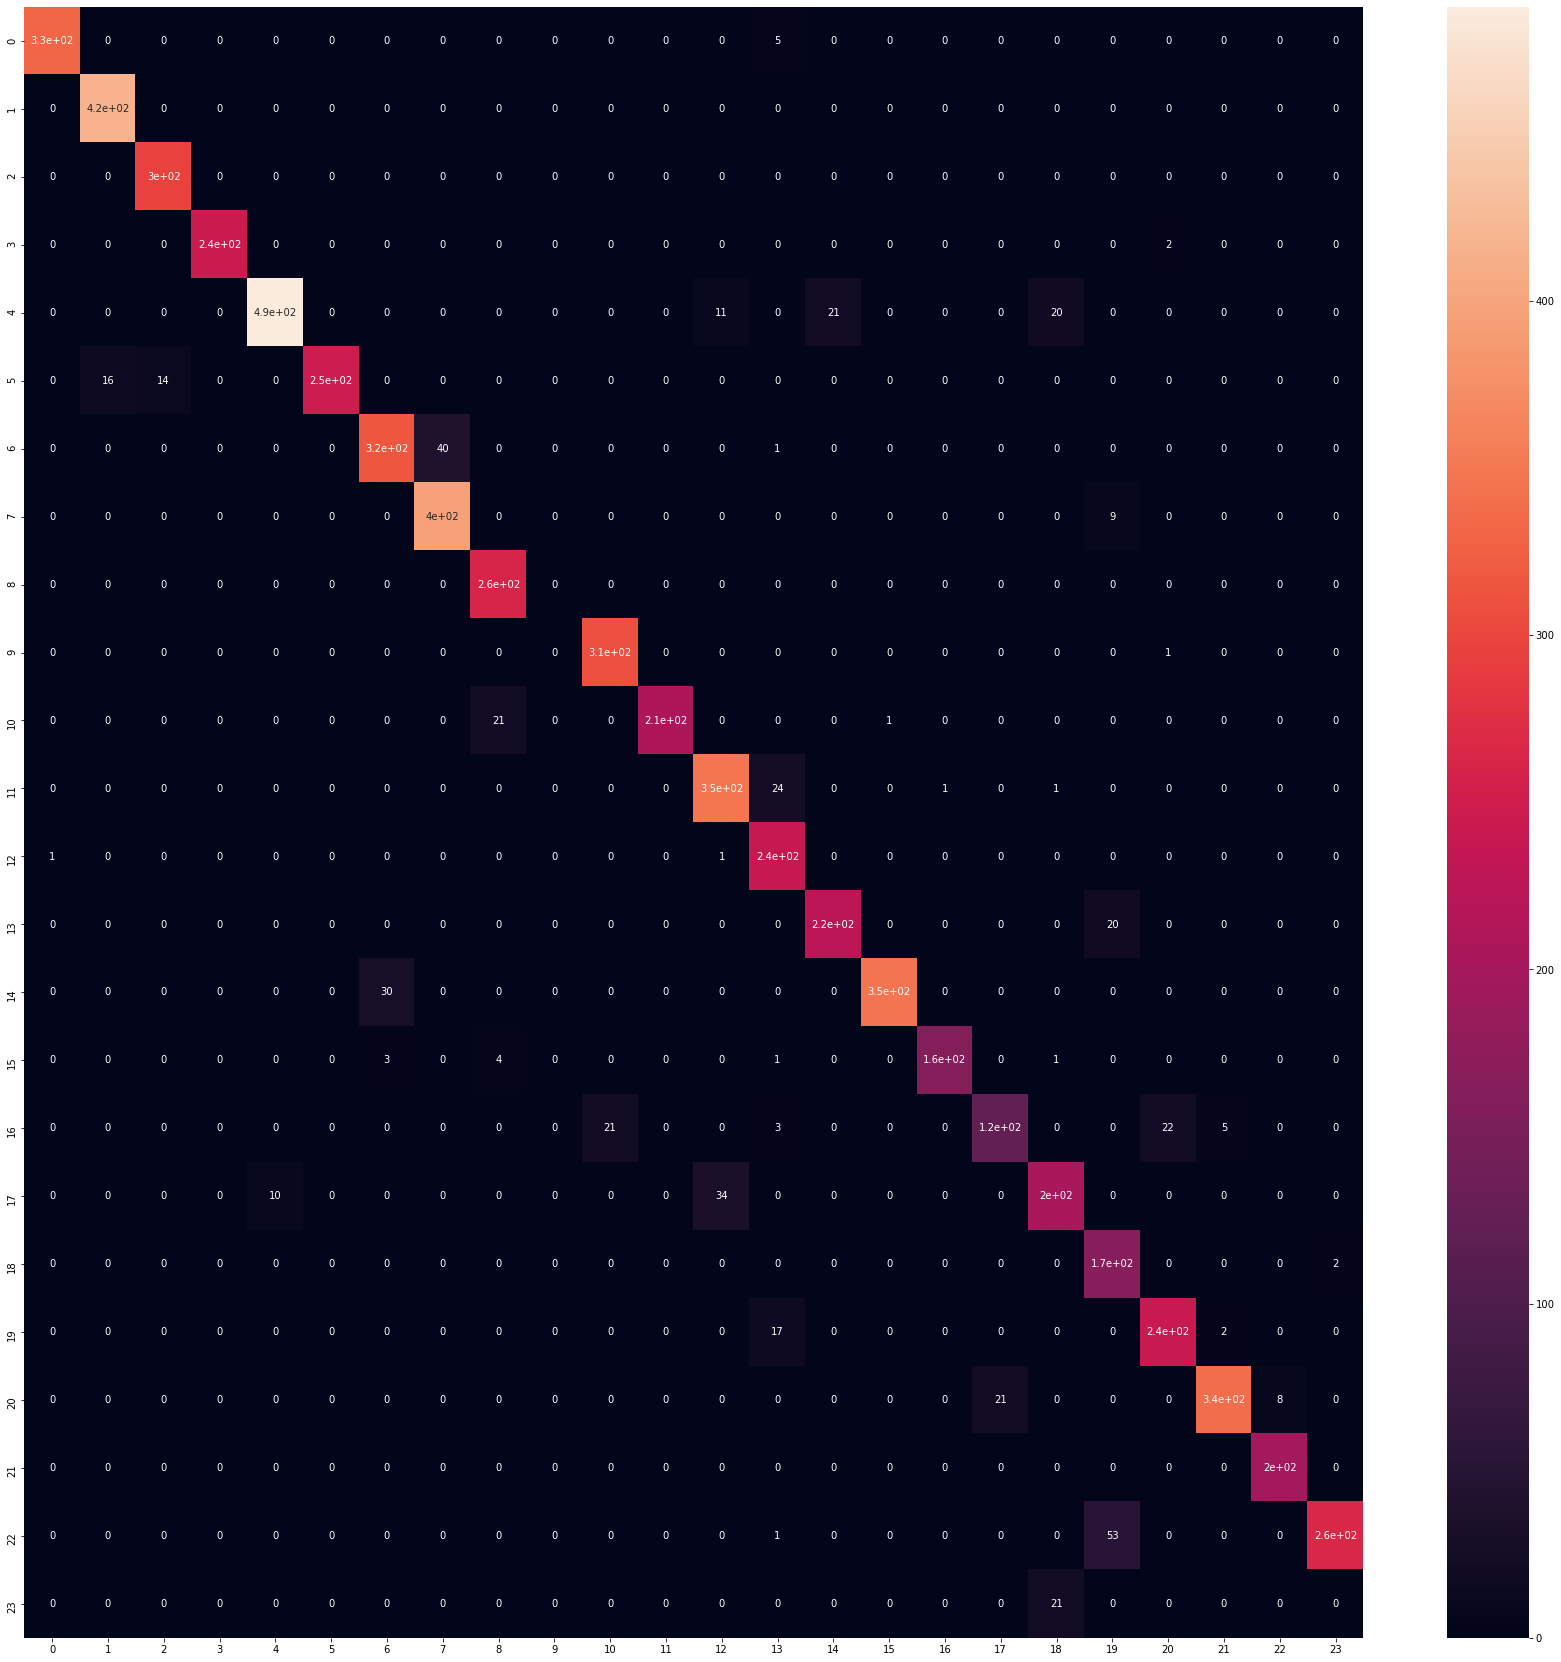

In [24]:
### confusion matrix ###

# predictions
y_pred = classifier.predict(df_test_X)

# confusion matrix
cm = confusion_matrix(y_pred, df_test_y, np.arange(24))

# plotting confusion matrix
plt.figure(figsize = (30, 30))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

In general, we can see that most values are predicted correctly. We can see that class = 9 does not have any representation. It is because class = 9 refers to J which is a dynamic sign and was not taken pictures of.

In the confusion matrix, values that have a large amount of false positives are signs that are quite similar. For example, class = 19 (S) is very similar to class = 12 (M). 

## Conclusion

In conclusion, we believe that we have built a good model for the identification of the alphabet in ASL. A lot of the errors come from signs that are very similar to eachother. If we were to improve our model in the future, the following would need to be done: 
* test different batch sizes with a grid search to see if we are potentially stuck in a local minima
* add the dynamic signs, J and Z, and have an image of a point in the sign that is unique